In [25]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
# import pickle
import nibabel as nib
# from nilearn.image import load_img
from nilearn.glm.first_level import FirstLevelModel
# from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain
# from matplotlib.backends.backend_pdf import PdfPages

In [26]:
# Directories

SOURCEDIR = os.path.join( os.path.expanduser("~"), 
                          'neurospin/icortex/iCortexDatabase/06-fMRI')
STIMDIR = os.path.join(SOURCEDIR, "03-BidsConversion")
DATADIR = os.path.join(SOURCEDIR, "04-fMRIPrep")
SAVEDIR = os.path.join(SOURCEDIR, "06-FirstLevelContrastAnalysis")
CACHEDIR = os.path.join(SOURCEDIR, ".CACHE")

if not os.path.exists( SAVEDIR ) :
  os.makedirs( SAVEDIR )

In [27]:
subj = 1
session_label = '09'
SPACE = 'T1w'
TASK = 'ml'

RUNS = [1, 2 , 3, 4, 5]

In [28]:
CONFOUNDS = list()

N_ACOMP = 6

CONFOUNDS += [ "trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z" ]
CONFOUNDS += [ f"a_comp_cor_{i:02d}" for i in range( N_ACOMP ) ]
CONFOUNDS += [ "csf", "white_matter" ]

In [29]:
TRIAL_TYPE = {
    '01-PseudowordList': '01-PseudowordList',
    '02-WordList': '02-WordList',
    '03-MeaninglessSentence': '03-MeaninglessSentence',
    '04-FactualKnowledge': '04-FactualKnowledge',
    '05-ContextualKnowledge': '05-ContextualKnowledge',
    '06-TheoryOfMind': '06-TheoryOfMind',
    '07-ArithmeticPrinciple': '07-ArithmeticPrinciple',
    '08-Calculation': '08-Calculation',
    '09-Geometry': '09-Geometry',
    'V': '10-PressV',
    'F': '11-PressF'
}

In [30]:
def get_confounds(cfndfile, n_acomp=6):
        
    cfnds = pd.read_csv(
            cfndfile,
            delimiter="\t")
    mvmt_cfnds = [ "trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z" ]
    pca_cfnds = [ f"a_comp_cor_{i:02d}" for i in range( n_acomp ) ]
    brain_cfnds = [ "csf", "white_matter" ]
    confounds = mvmt_cfnds + pca_cfnds + brain_cfnds

    return cfnds[confounds]

In [31]:
def get_events(eventfile, trial_type_dict=TRIAL_TYPE):
    
    df = pd.read_csv(eventfile, sep='\t')
    df = df[df.sentence != 't']
    df.loc[df.trial_type == 'keypressed', 'trial_type'] = df.loc[df.trial_type == 'keypressed', 'sentence']
    df = df[['onset', 'duration', 'trial_type']]
    df = df[df.trial_type.isin(trial_type_dict.keys())]
    df = df.replace(trial_type_dict)
    
    return df

In [32]:
def create_flm(subj):
    
    events_df = []
    func_files = []
    confounds_df = []


    for run in RUNS:

        # Declare files
        file_id = f"sub-{subj:02}_ses-{session_label}_task-{TASK}_dir-ap_run-{run:02}"

        cfndfile = os.path.join(
            DATADIR,
            f"sub-{subj:02}",
            f"ses-{session_label}",
            "func",
            f"{file_id}_desc-confounds_timeseries.tsv")

        TRfile = os.path.join(
            STIMDIR,
            f"sub-{subj:02}",
            f"ses-{session_label}",
            "func",
            f"{file_id}_bold.json")

        onsetfile = os.path.join(
            STIMDIR,
            f"sub-{subj:02}",
            f"ses-{session_label}",
            "func",
            f"{file_id}_events.tsv")

        funcfile = os.path.join(
            DATADIR,
            f"sub-{subj:02}",
            f"ses-{session_label}",
            "func",
            f"{file_id}_space-{SPACE}_desc-preproc_bold.nii.gz")


        # Prepare GLM entries
        events_df.append(get_events(onsetfile))
        func_files.append(funcfile)
        confounds_df.append(get_confounds(cfndfile))
        with open(TRfile) as f:
            TR = json.load(f)["RepetitionTime"]

    # Estimate GLM
    flm = FirstLevelModel(
            t_r = TR,
            hrf_model='spm',
            memory=CACHEDIR,
            n_jobs=len(RUNS)
        )

    flm.fit(
        func_files,
        events=events_df,
        confounds=confounds_df
        )

    return flm

In [33]:
flm = create_flm(subj)

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(294, 37)
(294, 37)
(294, 37)
(294, 37)
(294, 37)


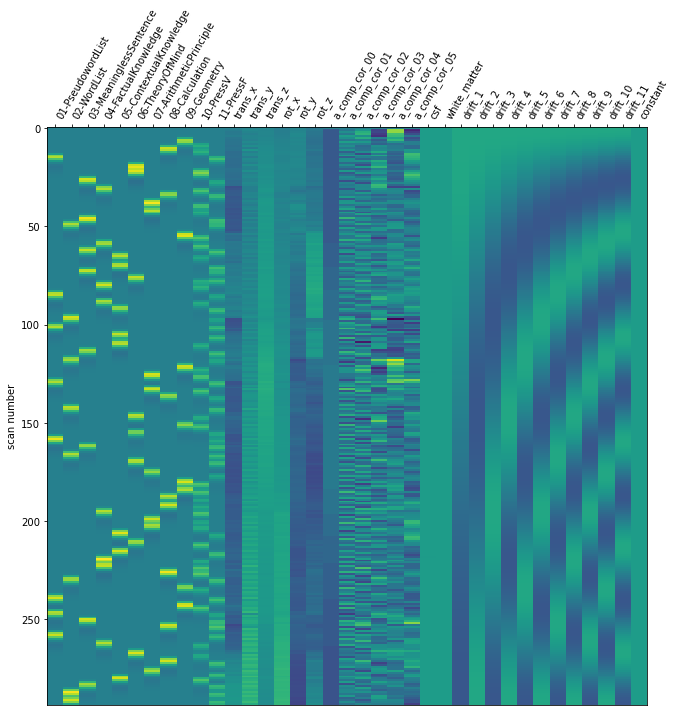

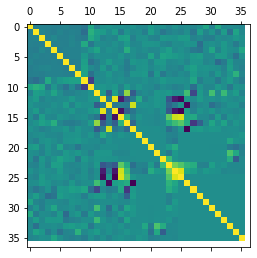

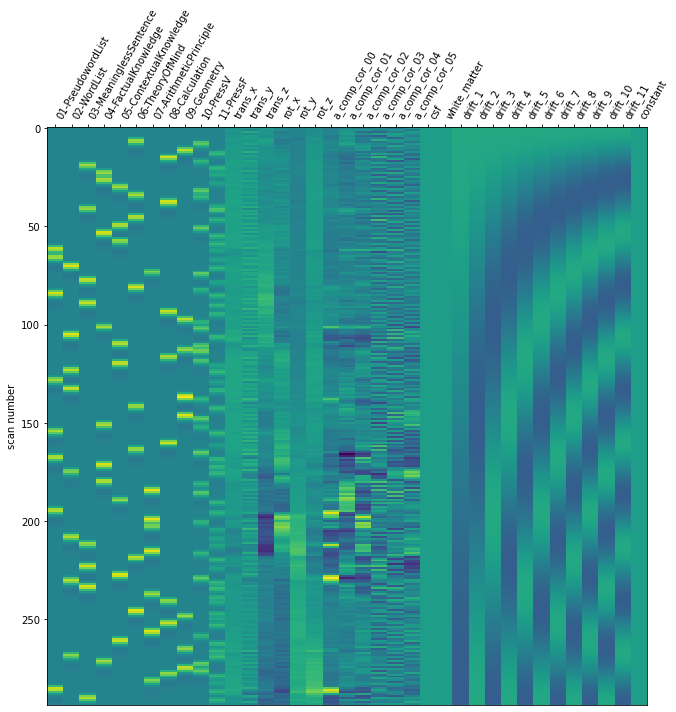

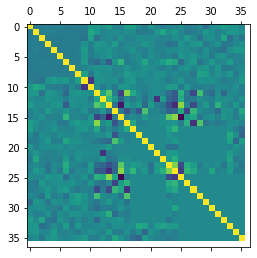

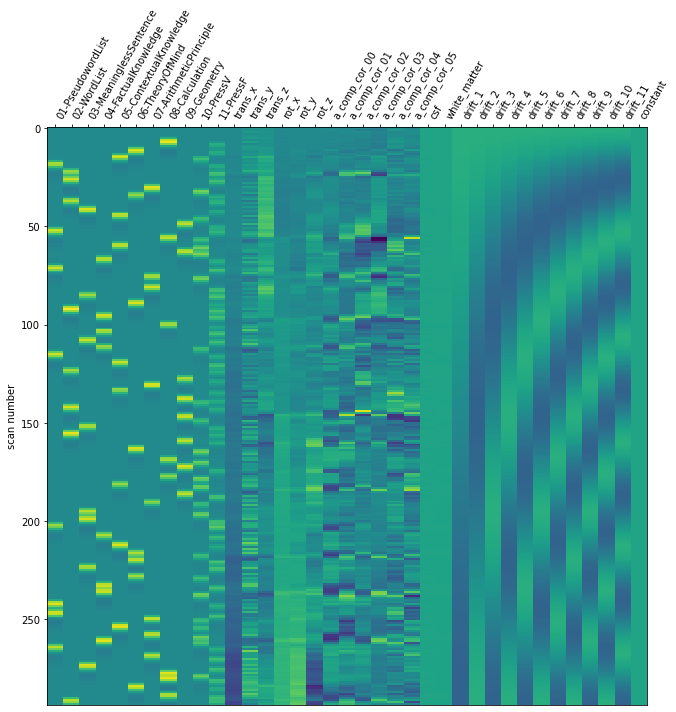

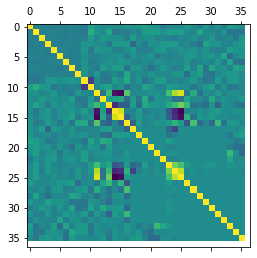

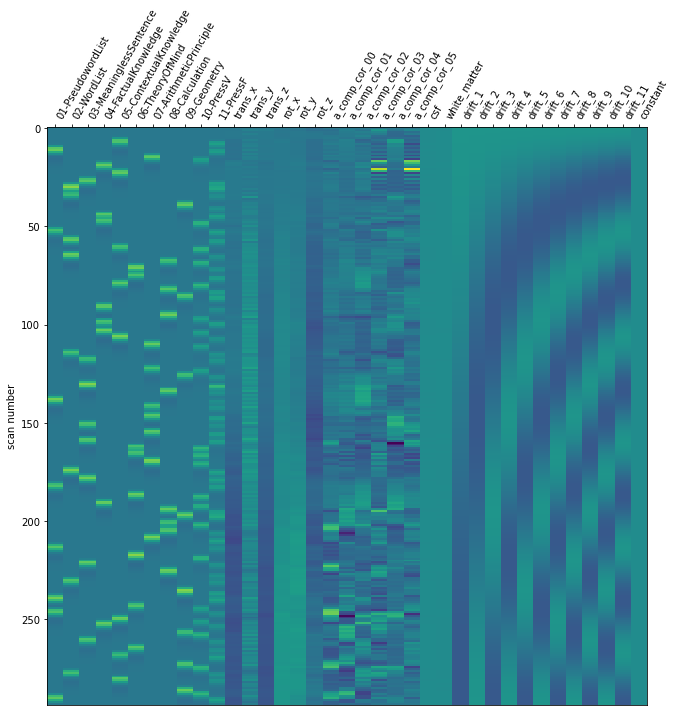

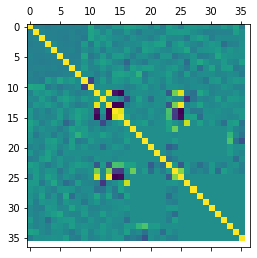

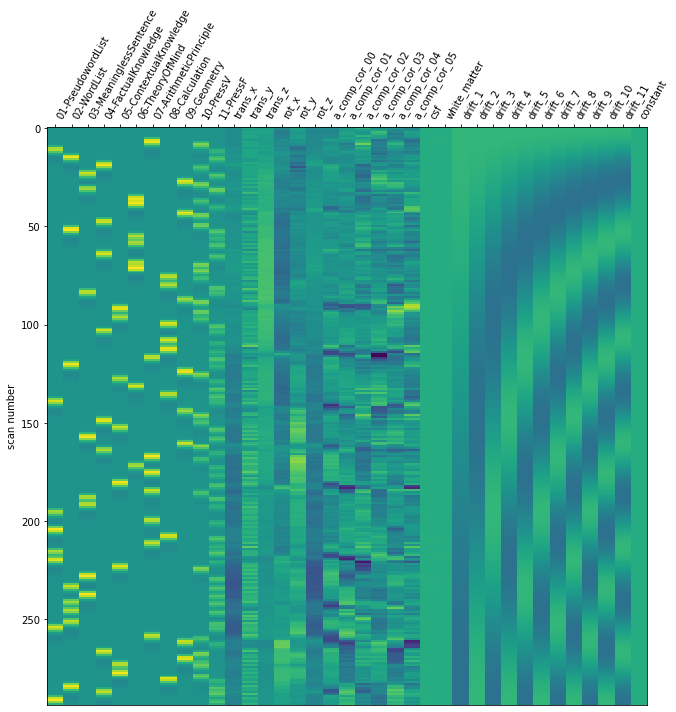

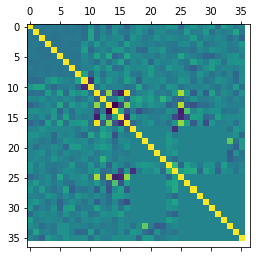

In [34]:
mat = flm.design_matrices_
for run in RUNS:
    plot_design_matrix(mat[run-1])
    plt.matshow(np.corrcoef(mat[run-1].T))
    print(mat[run-1].shape)

In [ ]:
def compute_contrast(conds, cfnds, fname):

    Id = np.eye( len(conds) + len(cfnds) )

    contrasts_baseline = pd.DataFrame(data=Id[len(conds),:], columns=conds, index=conds+cfnds)

    # create a DataFrame of contrasts that compares each condition against the mean of the others
    contrasts_paper = contrasts_baseline.subtract(contrasts_baseline[CONDS[1:]].mean(axis=1), axis=0)

    contrasts_paper.to_csv(fname, sep='\t')

    return contrasts_paper

In [35]:
conds = mat[0].columns
mat_size = len(conds)
Id = np.eye( mat_size )

contrasts_Base = {cond : Id[i,:] for i, cond in enumerate(conds)}

In [39]:
# Compute contrast against word list

contrasts_WL = {
    'PseudowordList_WL': contrasts_Base['01-PseudowordList'] - contrasts_Base['02-WordList'],
    'MeaninglessSentences_WL': contrasts_Base['03-MeaninglessSentence'] - contrasts_Base['02-WordList'],
    'FactualKnowledge_WL': contrasts_Base['04-FactualKnowledge'] - contrasts_Base['02-WordList'],
    'ContextualKnowledge_WL': contrasts_Base['05-ContextualKnowledge'] - contrasts_Base['02-WordList'],
    'TheoryOfMind_WL': contrasts_Base['06-TheoryOfMind'] - contrasts_Base['02-WordList'],
    'ArithmeticPrinciple_WL': contrasts_Base['07-ArithmeticPrinciple'] - contrasts_Base['02-WordList'],
    'Calculation_WL': contrasts_Base['08-Calculation'] - contrasts_Base['02-WordList'],
    'Geometry_WL': contrasts_Base['09-Geometry'] - contrasts_Base['02-WordList']
}

In [40]:
# Compute contrast against meaningless sentences

contrasts_MS = {
    'PseudowordList_MS': contrasts_Base['01-PseudowordList'] - contrasts_Base['03-MeaninglessSentence'],
    'WordList_MS': contrasts_Base['02-WordList'] - contrasts_Base['03-MeaninglessSentence'],
    'FactualKnowledge_MS': contrasts_Base['04-FactualKnowledge'] - contrasts_Base['03-MeaninglessSentence'],
    'ContextualKnowledge_MS': contrasts_Base['05-ContextualKnowledge'] - contrasts_Base['03-MeaninglessSentence'],
    'TheoryOfMind_MS': contrasts_Base['06-TheoryOfMind'] - contrasts_Base['03-MeaninglessSentence'],
    'ArithmeticPrinciple_MS': contrasts_Base['07-ArithmeticPrinciple'] - contrasts_Base['03-MeaninglessSentence'],
    'Calculation_MS': contrasts_Base['08-Calculation'] - contrasts_Base['03-MeaninglessSentence'],
    'Geometry_MS': contrasts_Base['09-Geometry'] - contrasts_Base['03-MeaninglessSentence']
}

In [41]:
# Compute contrast interesting for the paper

math = contrasts_Base['07-ArithmeticPrinciple'] + contrasts_Base['08-Calculation'] + contrasts_Base['09-Geometry']
lang = contrasts_Base['04-FactualKnowledge'] + contrasts_Base['05-ContextualKnowledge'] + contrasts_Base['06-TheoryOfMind']

contrasts_Paper = {
    'MathLang': math - lang,
    'LangMath': lang - math,
    'Tom_Context': contrasts_Base['06-TheoryOfMind'] - contrasts_Base['05-ContextualKnowledge'],
    'Context_Tom': contrasts_Base['05-ContextualKnowledge'] - contrasts_Base['06-TheoryOfMind'],
    'TomContext_Fact': contrasts_Base['06-TheoryOfMind'] + contrasts_Base['05-ContextualKnowledge'] - 2*contrasts_Base['04-FactualKnowledge'],
    'Fact_TomContext': 2*contrasts_Base['04-FactualKnowledge'] - contrasts_Base['06-TheoryOfMind'] - contrasts_Base['05-ContextualKnowledge']
}

In [42]:
contrasts_all = {}
contrasts_all.update(contrasts_Base)
contrasts_all.update(contrasts_WL)
contrasts_all.update(contrasts_MS)
contrasts_all.update(contrasts_Paper)

In [ ]:
for contrastId, contrast in contrasts_all.items():

    mapdir = os.path.join(
        SAVEDIR,
        f'sub-{subj:02}',
        f'ses-{session_label}')
    if not os.path.exists( mapdir ) :
        os.makedirs( mapdir )

    file_id = f"sub-{subj:02}_ses-{session_label}_task-{TASK}_run-all"

    mapfile = os.path.join(
        mapdir,
        f'{file_id}_contrast-{contrastId}.nii')
    
    
    stat_map = flm.compute_contrast(
        contrast,
        stat_type='t',
        output_type='z_score')
    
    nib.save(stat_map, mapfile)

In [64]:
from nilearn.image import threshold_img

b_thresh = 3.1
min_region_size = 10
mask = threshold_img(stat_map, b_thresh, cluster_threshold=min_region_size)


In [ ]:
# X = mat[0]
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif["features"] = X.columns
# print(vif)